In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
# hyperparameters
image_size = 32
patch_size = 16
num_channels = 3
num_classes = 10
d_model = 384
num_heads = 12
num_layers = 7
learning_rate = 2e-3
batch_size = 64
num_epochs = 20
dropout = 0

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seed
torch.manual_seed(42)

In [3]:
# data transforms (image augmentations)

transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

no_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [4]:
# Load the CIFAR-10 dataset
#torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" # fix URL error

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=no_transform, download=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


tensor(3)


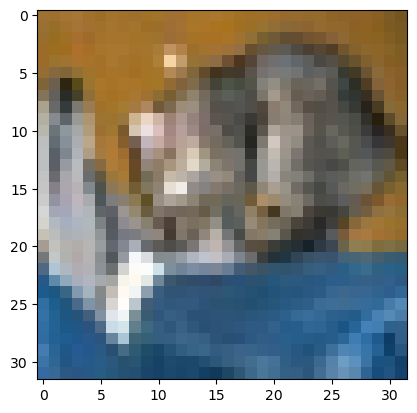

In [5]:
import matplotlib.pyplot as plt

image, label = next(iter(valid_dataloader))

assert image_size == image.shape[-1]
assert num_channels == image.shape[-3]

plt.imshow(denormalize(image)[0].permute(1,2,0))
print(label[0])

num_patches = (image_size // patch_size) ** 2
patch_embedding = nn.Conv2d(in_channels=1, out_channels=d_model, kernel_size=patch_size, stride=patch_size)
cls_token = nn.Parameter(torch.randn(1, 1, d_model))
pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, d_model))
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_model * 4, dropout=0.1)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
classification_head = nn.Linear(d_model, num_classes)

x = patch_embedding(image) # (B, C, H, W)
x = x.flatten(2).transpose(1, 2) # (B, T, C), T=H*W
(B, T, C) = x.shape
print(x.shape)

cls_tokens = cls_token.repeat(B, 1, 1) # (1, 1, C) -> (B, 1, C)
x = torch.cat([cls_tokens, x], dim=1) # (B, T+1, C)
print(str(cls_token.shape) + ' ->', str(cls_tokens.shape))
print(x.shape)

x = x + pos_embed[:, : T + 1] # (B, T+1, C)
print(pos_embed.shape, pos_embed[:, : T + 1].shape)
print(x.shape)

x = encoder(x)
print(x.shape)
x = x.mean(dim=1)
print(x.shape)
classification_head(x)
print(x.shape)

TODO act, conv bias

In [6]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, num_classes, embed_dim, num_heads, num_layers, is_cls_tok=False, dropout=0.5):
        super().__init__()
        self.is_cls_tok = is_cls_tok

        # Compute the number of patches
        self.num_patches = (image_size // patch_size) ** 2

        # Patch Embedding
        self.patch_embed = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size) # bias=False

        # Positional encoding
        if is_cls_tok:
            self.cls_tok = nn.Parameter(torch.randn(1, 1, embed_dim))
            self.pos_emb = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))
        else:
            self.cls_tok = None
            self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4, dropout=0.1)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Layer Norm
        self.ln = nn.LayerNorm(embed_dim)

        # Classification Head
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        # Patch Embedding
        x = self.patch_embed(x) # (B, C, H, W)

        # reshape Patches into sequence
        x = x.flatten(2).transpose(1, 2) # (B, T, C), T=H*W
        B, T, C = x.shape

        # add Class Token
        if self.is_cls_tok:
            cls_tokens = self.cls_tok.repeat(B, 1, 1) # (1, 1, C) -> (B, 1, C)
            x = torch.cat([cls_tokens, x], dim=1)

        # add Positional Embedding
        x = x + self.pos_emb # [:, : T + 1, :]

        # Dropout
        x = self.dropout(x)

        # Transformer Encoder
        x = self.encoder(x)

        # Classification Head
        if self.is_cls_tok:
            x = x[:,0]
        else:
            x = x.mean(dim=1)  # global average pooling
        x = self.ln(x)
        x = self.classification_head(x)

        return x

In [7]:
# define model
model = ViT(image_size, patch_size, num_channels, num_classes, d_model, num_heads, num_layers, is_cls_tok=False, dropout=dropout).to(device)
print('# of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
# model = torch.compile(model) # requires pytorch >= 2.0

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# loss function
criterion = nn.CrossEntropyLoss()

# of parameters: 12722698


In [8]:
model(torch.randn(64,3,32,32))[0]

tensor([-0.1668,  0.1653, -0.1987, -0.0517, -0.3182, -0.4312,  0.4526,  0.4717,
         0.0242,  0.2208], grad_fn=<SelectBackward0>)

In [9]:
def train(model, dataloader):

    model.train()

    # accumulate loss across batches
    running_loss = 0.0
    running_accuracy = 0.0

    for x, y in dataloader:
        #x, y = batch[0], batch[1] # move to device

        optimizer.zero_grad() # reset gradients
        y_pred = model(x) # forward pass
        loss = criterion(y_pred, y) # calculate loss
        loss.backward() # compute gradients
        optimizer.step() # optimization step

        running_loss += loss
        running_accuracy += (y_pred.argmax(dim=1) == y).float().mean()

    # average loss across batches
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    return loss, accuracy

In [10]:
@torch.no_grad()
def valid(model, dataloader):

    model.eval()

    # accumulate loss across batches
    running_loss = 0.0
    running_accuracy = 0.0

    for x, y in dataloader:
        #x, y = x.to(device), y.to(device) # move to device

        y_pred = model(x) # forward pass
        loss = criterion(y_pred, y) # calculate loss

        running_loss += loss
        running_accuracy += (y_pred.argmax(dim=1) == y).float().mean()
    
    # average loss across batches
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    return loss, accuracy

In [11]:
# keeping track of losses as it happen
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    print(f'epoch {epoch}')
    print('training')
    loss, accuracy = train(model, train_dataloader)
    train_losses.append(loss)
    train_accs.append(accuracy)
    print(f'loss: {loss}, accuracy: {accuracy}')
    
    print('validating')
    loss, accuracy = valid(model, train_dataloader)
    valid_losses.append(loss)
    valid_accs.append(accuracy)
    print(f'val_loss: {loss}, val_accuracy: {accuracy}')

epoch 0
training
loss: 2.3375003337860107, accuracy: 0.09938459098339081
validating
val_loss: 2.30583119392395, val_accuracy: 0.09996403753757477
epoch 1
training
loss: 2.305652141571045, accuracy: 0.09840553253889084
validating
val_loss: 2.303351640701294, val_accuracy: 0.10002397745847702
epoch 2
training
loss: 2.303988456726074, accuracy: 0.09954443573951721
validating
val_loss: 2.3028640747070312, val_accuracy: 0.09996403753757477
epoch 3
training
loss: 2.303583860397339, accuracy: 0.10070332139730453
validating
val_loss: 2.3033993244171143, val_accuracy: 0.09996403753757477
epoch 4
training
loss: 2.3036396503448486, accuracy: 0.09824568778276443
validating
val_loss: 2.3028671741485596, val_accuracy: 0.09990409016609192
epoch 5
training
loss: 2.303689956665039, accuracy: 0.09852541238069534
validating
val_loss: 2.3034377098083496, val_accuracy: 0.10020380467176437
epoch 6
training
loss: 2.303866147994995, accuracy: 0.09792599081993103
validating
val_loss: 2.3030459880828857, val_ac

KeyboardInterrupt: 